##### Used in the Implementation of Decision Trees
Information Gain = E(Parent)-weighted average of E(Children)
E= -summation(p*log(p))
p = probability of a class

Stopping Criteria : Maximum Depth, Minimum number of samples before you divide, minimum impurity decrease
Video Reference: https://www.youtube.com/watch?v=NxEHSAfFlK8


In [19]:
# LIBRARIES HERE
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt



In [20]:
# Testing Function for Numpy Features
# testing bincount and argmax function
arrayy = np.array([1, 2, 5, 4, 5, 5, 7, 8, 8])
print(np.bincount(arrayy))
print(np.argmax(np.bincount(arrayy)))

[0 1 1 0 1 3 0 1 2]
5


In [21]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        # * used for leaf node creation
        self.feature = feature  # feature for separation
        self.threshold = threshold  # separation threshold
        self.left = left
        self.right = right  # left and right pointers
        self.value = value  # only for leaf nodes

    def is_leaf(self):
        if(self.value is None):
            return False
        else:
            return True


In [22]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split = min_samples_split #minimum number of samples in order to split a node since we dont want data to overfit at any cost
        self.max_depth = max_depth # maximum depth tree can take
        self.n_features = n_features  # number of features that need to considered
        self.max_depth_reached = 0
        self.root = None
    
    # About function tells you aboaut the decision tree
    def about(self):
        print("Decision Tree Classifier")
        print("min_samples_split: ", self.min_samples_split)
        print("max_depth: ", self.max_depth)
        print("n_features: ", self.n_features)
        print("max_depth_reached: ", self.max_depth_reached)
    
    # now that you are on the leaf node and don't want to split further, you need to return the most common label
    def most_common_label(self, y):
        return (np.argmax(np.bincount(y)))
    
    # either you define number of feature or you take all the features
    def fit(self, X, y):
        if(self.n_features == None):
            self.n_features = X.shape[1]
        else:
            if(self.n_features > X.shape[1]):
                self.n_features = X.shape[1]
        self.root = self._grow_tree(X, y)
    
    # it returns the feature you need to consider and the threshold value for that feature
    def _best_split(self, X, y, index_array):
        best_gain = -1
        split_index, split_threshold = None, None
        for idx in index_array:
            X_column = X[:, idx]
            thresholds = np.unique(X_column)
            # you consider all the values for that feature and find the one with best split
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_index = idx
                    split_threshold = threshold
                else :
                    best_gain = best_gain
                    split_index = split_index
                    split_threshold = split_threshold

        return split_threshold, split_index
    
    def _grow_tree(self, X, y, depth=0):
        n_samples= X.shape[0]
        n_features = X.shape[1]
        n_labels = len(np.unique(y))
        # Track the maximum depth
        if depth > self.max_depth_reached:
            self.max_depth_reached = depth
        # Check stopping criteria
        if ((depth >= self.max_depth) or (n_labels == 1) or( n_samples < self.min_samples_split)):
            # return new node simple
            leaf_value = self.most_common_label(y)
            return Node(value=leaf_value)

        # Find best split
        feat_index = np.random.choice(n_features, self.n_features, replace=False)
        best_threshold, best_feature = self._best_split(X, y, feat_index)

        # Create child nodes
        left_idxs,right_idxs = self._split(X[:, best_feature], best_threshold)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs , :], y[right_idxs ], depth+1)

        return Node(best_feature,best_threshold,left,right)

    def _entropy(self, y):
        hist = np.bincount(y)
        n=len(y)
        probs=hist/n
        return -np.sum([p * np.log2(p) for p in probs if p > 0])

    # calculate information gain 
    def _information_gain(self, y, X_column, threshold):
        parent_entropy = self._entropy(y)
        left_idx, right_idx = self._split(X_column, threshold)
        if len(left_idx) == 0 or len(right_idx) == 0:
            return 0
        n = len(y)
        pnleft= len(left_idx)/n
        entropy_left= self._entropy(y[left_idx])
        pnright= len(right_idx)/n
        entropy_right= self._entropy(y[right_idx])
        child_entropy = pnleft * entropy_left + pnright * entropy_right
        ig = parent_entropy - child_entropy
        return ig
            
    def _split(self, X_column, threshold):
        left_idx = np.argwhere(X_column <= threshold).flatten()
        right_idx = np.argwhere(X_column > threshold).flatten()
        return left_idx, right_idx
    
    def _traverse_tree(self, x, node):
        # recursion stops at leaf node
        if(node.is_leaf()):
            return node.value
        
        if(x[node.feature] <= node.threshold):
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)
                
    def predict(self,X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def accuracy(self,y_test, y_pred):
        return np.sum(y_test == y_pred) / len(y_test)
     


#### Write a code from scratch to train a Decision Tree Classifier to  predict  the  Genus  using  the  first  6  features  (MFCC_1  ,....,  MFCC_6) of given dataset by splitting the dataset into train and  test in the ratio of 20:80. 

In [26]:
# take the data and preprocess it
data=pd.read_csv('Q1Data.csv')
selected_features = ['MFCCs_ 1', 'MFCCs_ 2', 'MFCCs_ 3', 'MFCCs_ 4', 'MFCCs_ 5', 'MFCCs_ 6']
X = data[selected_features]
print(X.shape)
Y= data['Genus']
print(Y.shape)
le = LabelEncoder()
Y = le.fit_transform(Y)
clf = DecisionTree(max_depth=10)
X = X.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.8, random_state=42)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
accuracy_metric= clf.accuracy(y_test, predictions)

print(accuracy_metric)
print(clf.about())

(7195, 6)
(7195,)
0.8855107713690062
Decision Tree Classifier
min_samples_split:  2
max_depth:  10
n_features:  6
max_depth_reached:  10
None


#### Plot  the  test  accuracy  by  pruning  the  tree  to  a  depth  ranging  from 1,2,.....15.

In [27]:
max_depths = range(1, 16)
test_accuracies = []

for depth in max_depths:
    clf = DecisionTree(max_depth=depth)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    acc = clf.accuracy(y_test, predictions)
    test_accuracies.append(acc)


[0.6926685198054204, 0.7564280750521195, 0.8021195274496178, 0.8288742182070883, 0.857539958304378, 0.873870743571925, 0.8835997220291869, 0.8886379430159833, 0.891591382904795, 0.8886379430159833, 0.8823835997220292, 0.885858234885337, 0.8844683808200139, 0.8860319666435025, 0.8896803335649757]


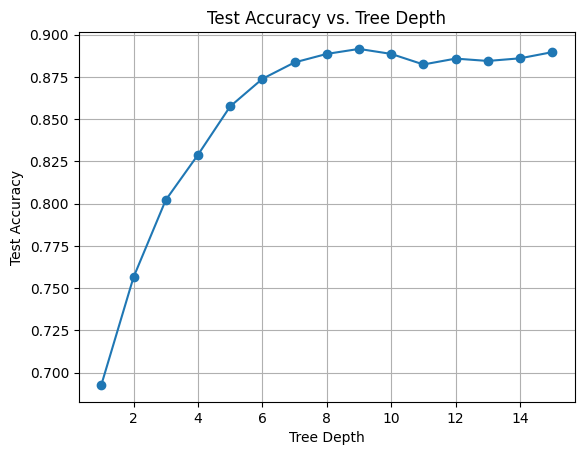

In [28]:
# Plot the results
print(test_accuracies)
plt.plot(max_depths, test_accuracies, marker='o')
plt.title('Test Accuracy vs. Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

#### What are your observations from the graph plotted above.

The graph shows that when the tree is not very deep, the accuracy is only around 60 percent, meaning the model is quite basic. As the tree gets deeper, accuracy improves and reaches its best point at a depth of 9. After that, making the tree even deeper doesn't help much and might even make things worse. 

Two main reasons for this: 

1. **Model Has Explored Enough:** The model has already learned a lot about the data by the time it reaches a depth of 9. Going deeper doesn't add much useful information because it has already figured out the important patterns.

2. **Overfitting:** When the tree becomes too deep, it starts memorizing the training data too much, like trying to remember a book instead of understanding the story. This makes the model perform worse on new, unseen data because it's too tailored to the training set.

So, there's a sweet spot where the tree is deep enough to capture important stuff but not so deep that it starts messing things up.